In [1]:
!pip install --upgrade pyfluidsynth

In [2]:

!pip install pretty_midi

In [ ]:
import collections
import datetime

: 

In [8]:

import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [9]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

SAMPLING_RATE = 16000 # Sampling rate for audio playback

In [10]:

data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 4s 0us/step


In [11]:

filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [12]:
sample_file = filenames[1]
print(sample_file)

data\maestro-v2.0.0\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi


In [13]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [14]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=SAMPLING_RATE)
    waveform_short = waveform[:seconds*SAMPLING_RATE]
    return display.Audio(waveform_short, rate=SAMPLING_RATE)

AttributeError: 'PrettyMIDI' object has no attribute 'show'

In [20]:
import midi2audio 
from midi2audio import FluidSynth as fs

In [21]:
fs().play_midi('piano/pianoscore_0.mid')

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [24]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [25]:
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=31, note_name=G1, duration=0.0656
1: pitch=43, note_name=G2, duration=0.0792
2: pitch=44, note_name=G#2, duration=0.0740
3: pitch=32, note_name=G#1, duration=0.0729
4: pitch=34, note_name=A#1, duration=0.0708
5: pitch=46, note_name=A#2, duration=0.0948
6: pitch=48, note_name=C3, duration=0.6260
7: pitch=36, note_name=C2, duration=0.6542
8: pitch=53, note_name=F3, duration=1.7667
9: pitch=56, note_name=G#3, duration=1.7688


In [31]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)
    
    sorted_notes = sorted(instrument.notes, key = lambda note: note.start)
    prev_start = sorted_notes[0].start
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start-prev_start)
        notes['duration'].append(end-start)
        prev_start = start
    
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [32]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,43,1.032292,1.111458,0.000000,0.079167
1,31,1.040625,1.106250,0.008333,0.065625
2,44,1.142708,1.216667,0.102083,0.073958
3,32,1.144792,1.217708,0.002083,0.072917
4,46,1.208333,1.303125,0.063542,0.094792


In [33]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['G2', 'G1', 'G#2', 'G#1', 'A#2', 'A#1', 'C3', 'C2', 'F3', 'D4'],
      dtype='<U3')

In [34]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20,4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis = 0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis = 0)
    plt.plot(
        plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker="."
    )
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

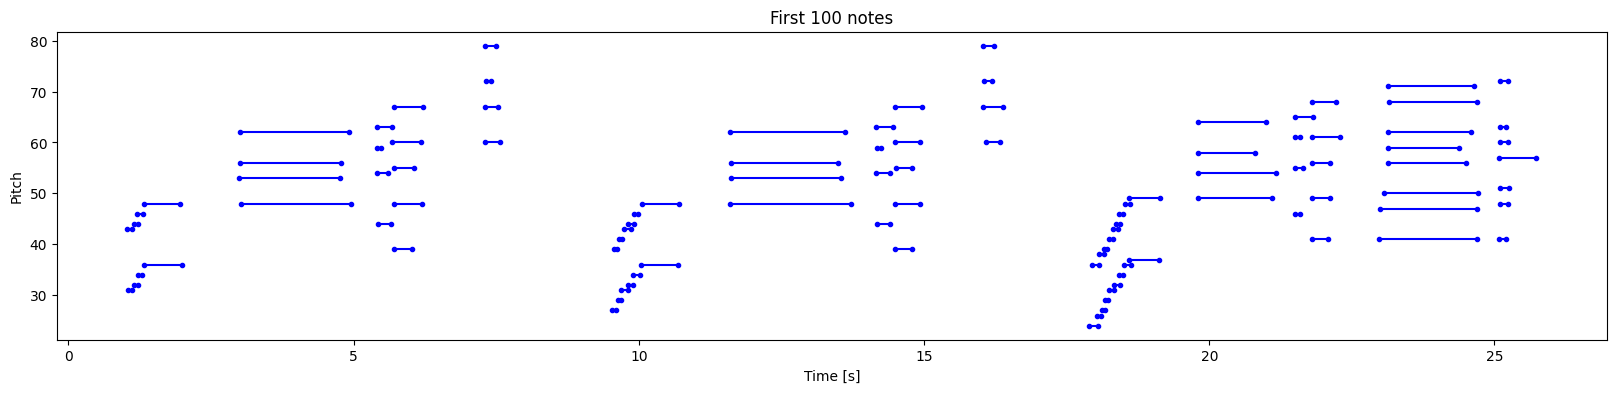

In [35]:
plot_piano_roll(raw_notes, count=100)

In [39]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)
    
    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
    
    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

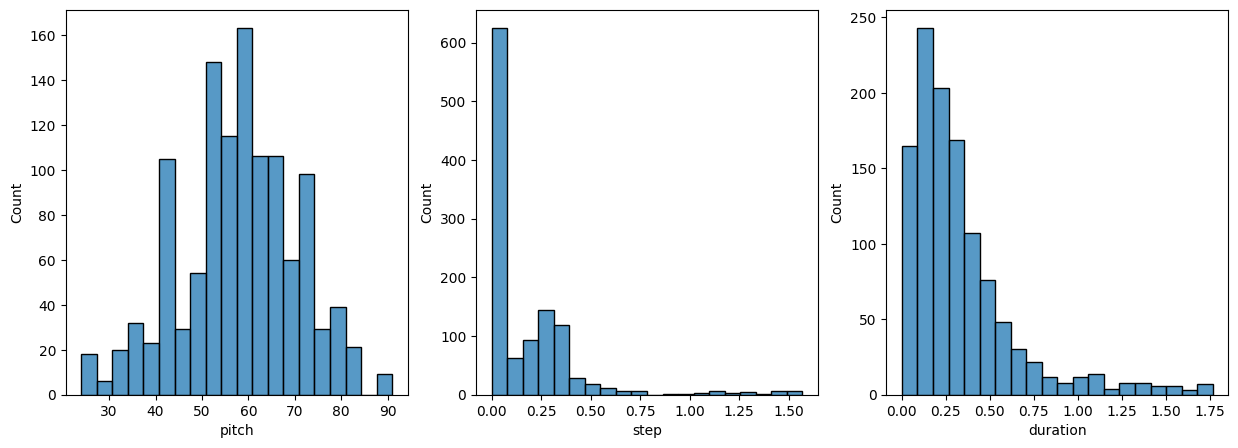

In [40]:
plot_distributions(raw_notes)

In [45]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [46]:
example_file = 'example.mid'
example_pm = notes_to_midi(
raw_notes, out_file=example_file, instrument_name=instrument_name)

In [47]:
#Creating dataset

In [49]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [50]:
n_notes = len(all_notes)
print('Notes parsed:', n_notes)

Notes parsed: 37241


In [51]:
# tf.data.Dataset

In [52]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [53]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [57]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [58]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [59]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5546875  0.         0.096875  ]
 [0.4296875  0.18645833 0.21770833]
 [0.5546875  0.009375   0.50520833]
 [0.4609375  0.175      0.16770833]
 [0.484375   0.16979167 0.11979167]
 [0.5625     0.153125   0.04166667]
 [0.5234375  0.01666667 0.196875  ]
 [0.578125   0.18020833 0.11458333]
 [0.4453125  0.         0.53958333]
 [0.5625     0.05416667 0.06875   ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=59.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.008333333333333304>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.15937500000000027>}


In [61]:
batch_size = 64
buffer_size = n_notes - seq_length
train_ds = (seq_ds
           .shuffle(buffer_size)
           .batch(batch_size, drop_remainder=True)
           .cache()
           .prefetch(tf.data.experimental.AUTOTUNE))

In [62]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [67]:
# Creating and training the model

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [68]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          67584       ['input_3[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_2[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_2[0][0]']                 
                                                                                            

In [69]:
losses = model.evaluate(train_ds, return_dict=True)
losses

581/581 [==============================] - 10s 9ms/step - loss: 5.0077 - duration_loss: 0.1131 - pitch_loss: 4.8525 - step_loss: 0.0421


{'loss': 5.007681846618652,
 'duration_loss': 0.11310973018407822,
 'pitch_loss': 4.8524956703186035,
 'step_loss': 0.04207378625869751}

In [70]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration': 1.0,
    },
    optimizer=optimizer
)

In [71]:
model.evaluate(train_ds, return_dict=True)

581/581 [==============================] - 5s 8ms/step - loss: 0.3978 - duration_loss: 0.1131 - pitch_loss: 4.8525 - step_loss: 0.0421


{'loss': 0.3978081941604614,
 'duration_loss': 0.11310973018407822,
 'pitch_loss': 4.8524956703186035,
 'step_loss': 0.04207378625869751}

In [72]:
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [84]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
581/581 [==============================] - 10s 17ms/step - loss: 0.2855 - duration_loss: 0.0694 - pitch_loss: 3.7218 - step_loss: 0.0300
Epoch 2/50
581/581 [==============================] - 14s 24ms/step - loss: 0.2839 - duration_loss: 0.0684 - pitch_loss: 3.7193 - step_loss: 0.0296
Epoch 3/50
581/581 [==============================] - 13s 22ms/step - loss: 0.2821 - duration_loss: 0.0675 - pitch_loss: 3.7095 - step_loss: 0.0291
Epoch 4/50
581/581 [==============================] - 14s 24ms/step - loss: 0.2789 - duration_loss: 0.0656 - pitch_loss: 3.6959 - step_loss: 0.0285
Epoch 5/50
581/581 [==============================] - 12s 21ms/step - loss: 0.2773 - duration_loss: 0.0656 - pitch_loss: 3.6919 - step_loss: 0.0271
Epoch 6/50
581/581 [==============================] - 13s 22ms/step - loss: 0.2771 - duration_loss: 0.0653 - pitch_loss: 3.6802 - step_loss: 0.0278
Epoch 7/50
581/581 [==============================] - 13s 23ms/step - loss: 0.2710 - duration_loss: 0.0626 - pit

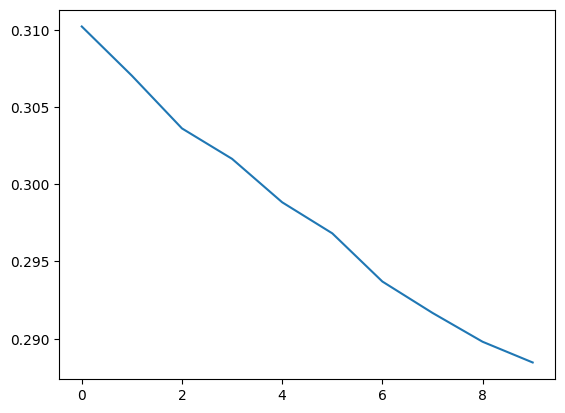

In [75]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [76]:
# Generating Notes

In [85]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [86]:
temperature = 0.6
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 20ms/step


In [82]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,38,0.184433,0.234084,0.184433,0.418517
1,48,0.179970,0.489534,0.364403,0.853936
2,44,0.275130,0.371216,0.639533,1.010748
3,44,0.280165,0.321875,0.919698,1.241573
4,44,0.280537,0.313181,1.200235,1.513417
5,97,0.282253,0.316097,1.482488,1.798585
6,44,0.264385,0.582343,1.746874,2.329217
7,44,0.285778,0.338581,2.032652,2.371233
8,44,0.274177,0.295178,2.306829,2.602008
9,97,0.283527,0.323294,2.590356,2.913650


In [87]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)